First we need a dataset to train on. Let's create a DataSet object directly from huggingface. The avaialable datasets are [here](https://huggingface.co/datasets/fastmachinelearning/collide-1m/tree/main). We want to train on QCD so let's use the "QCD inclusive" dataset which on hugging face is called: QCD_HT50toInf. We set the max_number_of_events to -1 to get all the data but this can be set to whatever is needed

In [1]:
from data.dataset import DataSet

/opt/conda/envs/tagger/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
QCD_data_set = DataSet.fromHF('QCD_HT50toInf',max_number_of_events=-1)
QCD_data_set.save_h5('dataset/QCD')

cpu count: 24
Add multiplicities
Pad Jets
Pad Objects
Process other columns
       FullReco_GenMissingET_MET  L1T_PUPPIMET_MET  L1T_PUPPIMET_Phi  \
count              799884.000000     799884.000000     799884.000000   
mean                    0.919171         27.683849         -0.001507   
std                     4.105609         26.306128          1.809750   
min                     0.000000          0.000000         -3.140625   
25%                     0.000000         12.843750         -1.565430   
50%                     0.000000         21.625000          0.000000   
75%                     0.335693         34.312500          1.563477   
max                   334.250000       1026.000000          3.140625   

       L1T_PUPPIMET_Eta  jet_multiplicity  muon_multiplicity  \
count     799884.000000     799884.000000       799884.00000   
mean          -0.004704          1.841798            0.04618   
std            2.601617          1.377498            0.21770   
min           -8.86

In [3]:
QCD_data_set.pretty_name = "QCD Inclusive"
QCD_data_set.plot_inputs('dataset/QCD')

plot jet features
plot object features
plot met features
plot gen features
plot multiplicity features


<Figure size 640x480 with 0 Axes>

Let's also get the diHiggs -> 4b dataset to be our testing "anomaly" and the minbias to be our "background"

In [4]:
minbias_data_set = DataSet.fromHF('minbias',max_number_of_events=-1)
minbias_data_set.pretty_name = "minimum bias"
minbias_data_set.save_h5('dataset/minbias')
minbias_data_set.plot_inputs('dataset/minbias')


cpu count: 24
Add multiplicities
Pad Jets
Pad Objects
Process other columns
       FullReco_GenMissingET_MET  L1T_PUPPIMET_MET  L1T_PUPPIMET_Phi  \
count             1000000.000000    1000000.000000    1000000.000000   
mean                    0.060143          6.829660         -0.004615   
std                     0.351896          9.358663          1.371867   
min                     0.000000          0.000000         -3.140625   
25%                     0.000000          0.000000         -0.408203   
50%                     0.000000          2.916016          0.000000   
75%                     0.000000         10.765625          0.383057   
max                    24.859375        219.500000          3.140625   

       L1T_PUPPIMET_Eta  jet_multiplicity  muon_multiplicity  \
count    1000000.000000    1000000.000000     1000000.000000   
mean           0.012181          0.164354           0.029348   
std            1.775172          0.426757           0.172860   
min           -9.40

<Figure size 640x480 with 0 Axes>

In [5]:

hhbbbb_data_set = DataSet.fromHF('HH_4b',max_number_of_events=-1)
hhbbbb_data_set.pretty_name = "HH -> bbbb"
hhbbbb_data_set.save_h5('dataset/hhbbbb')
hhbbbb_data_set.plot_inputs('dataset/hhbbbb')

cpu count: 24
Add multiplicities
Pad Jets
Pad Objects
Process other columns
       FullReco_GenMissingET_MET  L1T_PUPPIMET_MET  L1T_PUPPIMET_Phi  \
count               19984.000000      19984.000000      19984.000000   
mean                   16.224879         56.476293          0.015636   
std                    21.154812         50.527088          1.820133   
min                     0.000000          0.155273         -3.140625   
25%                     3.312500         26.968750         -1.578125   
50%                     9.710938         44.187500          0.040009   
75%                    21.328125         69.875000          1.599609   
max                   400.250000       1120.000000          3.140625   

       L1T_PUPPIMET_Eta  jet_multiplicity  muon_multiplicity  \
count      19984.000000      19984.000000       19984.000000   
mean          -0.011880          4.612940           0.407476   
std            2.886597          1.644614           0.629033   
min           -9.42

<Figure size 640x480 with 0 Axes>

As we are using these datasets for training an autoencoder having very different feature distributions will lead to poor training so let's normalise the data between 0 and 1 by performing a minmax normalisation, i.e. (x - min(x)) / (max(x) - min(x)). If you need a standard deviation normalisation, i.e. (x - mean(x))/ std(x) set minmax in the function call to false.

In [6]:
QCD_data_set.normalise(minmax=True)

Models for training follow a common format. They are a python class that holds a few abstract methods for us to define for a given model. This means that a autoencoder model or Quantum embedding model can be trained with the same .fit command with the same data.

Let's quickly walk through the model class for the AutoEncoderModel.py. First imports 

```
import os # needed for saving

import numpy as np # needed for numpy things 
import numpy.typing as npt 

from model.AnomalyDetectionModel import ADModelFactory, ADModel # needed for the base class, any child class written needs these imports

```
next come specific keras imports for this model class, equivalents would be needed for pytorch or other training frameworks
```
import keras
from keras.models import load_model
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

import tensorflow as tf

from sklearn.metrics import mean_absolute_error
```
Next the class definition. The weird @ syntax is a decorator and wraps our custom model definition with a registering function of the model factory class. This means we can create an object of our custom class directly from a yaml config or a folder and pass a generic model object to later downstream commands, e.g. "model.fit" "model.predict" without the downstream code caring about how the .predict or .fit were implemented by us in our model class's code. This doesn't really matter but it is essential to have this line before any new model class we create with a unique string in the register command that is the same as the model class name

The second line is the class definition itself. A class that inherits from the generic ADModel

```
@ADModelFactory.register('AutoEncoderModel')
class AutoEncoderModel(ADModel):

```
We then need to define some functions that any custom model needs. First build model that defines the actual model structure inside the AutoEncoderModel class. This is a simple autoencoder that takes an input shape derived from the dataset we are using and passes it through sequentual compression and then decompression layers to spit out a vector the same size as our original. The layer shapes themselves are taken from a yaml config that defines the model structure with the model_config. Hyperparameters can be added to these yaml configs and accessed with dictionary keys. On creation of the model class we read the yaml config and create the model_config and training_config for us to later access
```
def build_model(self, inputs_shape: tuple):
    """build model override, makes the model layer by layer

    Args:
        inputs_shape (tuple): Shape of the input
    """
        
    inputs = keras.layers.Input(shape=(inputs_shape,), name='model_input')
    for ienc, depthenc in enumerate(self.model_config['encoder_layers']):
            if ienc == 0:
                encoder = Dense(depthenc, activation='relu')(inputs)
            else:
                encoder = Dense(depthenc, activation='relu')(encoder)

    encoder = Dense(self.model_config['latent_dim'],activation='relu')(encoder)
                
    for idec, depthdec in enumerate(self.model_config['decoder_layers']):
            if idec == 0:
                decoder = Dense(depthdec, activation='relu')(encoder)
            else:
                decoder = Dense(depthdec, activation='relu')(decoder)
        
    decoder = Dense(inputs_shape,activation='sigmoid',name='model_output')(decoder)
                
    self.AD_model = keras.Model(inputs=inputs, outputs=decoder)
```


Now we can also include the compile_model step. For this keras model this involves creating the callbacks used for training scheduling using the hyperparameters in the yaml config. We can then also set the optimizer and loss function for the model. Any custom losses etc. can be defined here or more directly called in the model's train step in needed. See the VariationalAutoEncoder model for an example of this

```
def compile_model(self):
    """compile the model generating callbacks and loss function
    Args:
    """
    self.callbacks = [
        EarlyStopping(monitor='val_loss', patience=self.training_config['EarlyStopping_patience']),
        ReduceLROnPlateau(
                monitor='val_loss',
                factor=self.training_config['ReduceLROnPlateau_factor'],
                patience=self.training_config['ReduceLROnPlateau_patience'],
                min_lr=self.training_config['ReduceLROnPlateau_min_lr'],
            ),
    ]

    # compile the tensorflow model setting the loss and metrics
    self.AD_model.compile(
            optimizer='adam',
            loss='mae',
            metrics= ['mae', 'mean_squared_error'],
    )

```

Now we can define the fit function. As this is an self supervised autoencoder we have no y_train and only a train numpy array. We then directly call the keras fit on the model. For other training frameworks this could be implemented in a per epoch for loop or something more complicated but so long as the fit function takes a single train dataset argument whatever happens in this fit function is up to you.
```
def fit(
        self,
        train: npt.NDArray[np.float64],
    ):
        """Fit the model to the training dataset

    Args:
            train (npt.NDArray[np.float64]): X train dataset
        """
    # Train the model using hyperparameters in yaml config
    keras.config.disable_traceback_filtering()
        
    history = self.AD_model.fit(
            train.to_numpy(),
            train.to_numpy(),
            epochs=self.training_config['epochs'],
            batch_size=self.training_config['batch_size'],
            verbose=self.run_config['verbose'],
            validation_split=self.training_config['validation_split'],
            shuffle=True,
            callbacks=self.callbacks,
    )
        
    self.history = history.history

```

Model predict function, does what you may expect:

```
def predict(self, X_test) -> float:
    """Predict method for model

    Args:
        X_test (npt.NDArray[np.float64]): Input X test

    Returns:
            float: model prediction
    """
    model_outputs = self.AD_model.predict(X_test)
    ad_scores = tf.keras.losses.mae(model_outputs, X_test)
    ad_scores = ad_scores._numpy()
    return ad_scores

```

Finally we have save and load functionality. Again we have the @ syntax that simply allows us to do a function within a function of the parent class, all it does is save the yaml config with the model itself. Whatever saving and loading you have needs to have these decorators but what's in the function is up to you. 

```
@ADModel.save_decorator
def save(self, out_dir: str = "None"):
    """Save the model file

    Args:
            out_dir (str, optional): Where to save it if not in the output_directory. Defaults to "None".
    """
    # Export the model
    os.makedirs(os.path.join(out_dir, 'model'), exist_ok=True)
    # Use keras save format !NOT .h5! due to depreciation
    export_path = os.path.join(out_dir, "model/saved_model.keras")
    self.AD_model.save(export_path)
    print(f"Model saved to {export_path}")

@ADModel.load_decorator
def load(self, out_dir: str = "None"):
    """Load the model file

        Args:
            out_dir (str, optional): Where to load it if not in the output_directory. Defaults to "None".
    """
    # Load the model
    self.AD_model = load_model(f"{out_dir}/model/saved_model.keras")

```

Now let's train a model. First let's create a config dictionary directly. We can also do this with a yaml file like is shown in model/configs. Then create the model from the dictionary, specifying the ouput directly as well


In [7]:
import model
from model.common import fromDict,fromYaml

config_dict = {'model': 'AutoEncoderModel',
               'run_config' : {'verbose' : 2,
                               'debug' : True,
                               'num_threads' : 8},
               'model_config' : {'name' : 'autoencoder',
                                 'encoder_layers' : [32,16],
                                 'decoder_layers' : [24,32,64,128],
                                 'latent_dim': 8},
               'training_config' :{'epochs' : 100,
                                   'batch_size' : 256,
                                   'learning_rate' : 0.001,
                                   'validation_split' : 0.1,
                                   'EarlyStopping_patience' : 10,
                                   'ReduceLROnPlateau_factor' : 0.5,
                                   'ReduceLROnPlateau_patience' : 5,
                                   'ReduceLROnPlateau_min_lr' : 0.00001}}

AE_model = fromDict(config_dict,'output/autoencoder')

# Alternatively like this from a yaml config
#AE_model = fromYaml('model/configs/AutoEncoder.yaml','output/autoencoder')

2026-01-05 19:27:35.762103: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-05 19:27:35.786872: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Re-created existing directory: output/autoencoder.


2026-01-05 19:27:36.584105: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


First we need to know the input vector shape which we can derive from the input dataset. 
Then we can build the model and compile it ready for training

In [8]:
input_shape = len(QCD_data_set.training_columns)
AE_model.build_model(input_shape)
AE_model.compile_model()
    


2026-01-05 19:27:36.665974: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Now we can fit the model using the dataset. We use the "get_training_dataset()" function to ensure that the DataSet object passes a numpy array of the inputs rather than a weird pandas dataframe that isn't supported by all training frameworks

In [9]:
AE_model.fit(QCD_data_set.get_training_dataset())


Epoch 1/100
2813/2813 - 3s - 975us/step - loss: 0.0282 - mae: 0.0282 - mean_squared_error: 0.0074 - val_loss: 0.0205 - val_mae: 0.0205 - val_mean_squared_error: 0.0046 - learning_rate: 0.0010
Epoch 2/100
2813/2813 - 2s - 683us/step - loss: 0.0155 - mae: 0.0155 - mean_squared_error: 0.0034 - val_loss: 0.0147 - val_mae: 0.0147 - val_mean_squared_error: 0.0033 - learning_rate: 0.0010
Epoch 3/100
2813/2813 - 2s - 691us/step - loss: 0.0145 - mae: 0.0145 - mean_squared_error: 0.0033 - val_loss: 0.0142 - val_mae: 0.0142 - val_mean_squared_error: 0.0032 - learning_rate: 0.0010
Epoch 4/100
2813/2813 - 2s - 690us/step - loss: 0.0136 - mae: 0.0136 - mean_squared_error: 0.0031 - val_loss: 0.0128 - val_mae: 0.0128 - val_mean_squared_error: 0.0029 - learning_rate: 0.0010
Epoch 5/100
2813/2813 - 2s - 681us/step - loss: 0.0126 - mae: 0.0126 - mean_squared_error: 0.0029 - val_loss: 0.0125 - val_mae: 0.0125 - val_mean_squared_error: 0.0028 - learning_rate: 0.0010
Epoch 6/100
2813/2813 - 2s - 686us/step 

Save it so we can use it later

In [10]:
AE_model.save()

Model saved to output/autoencoder/model/saved_model.keras


Plot the loss to see how it trained

In [11]:
AE_model.plot_loss()

<Figure size 1700x1700 with 0 Axes>

Let's have a look at the model outputs first by runnning predict on our datasets (make sure they are normalised) and then using the histo plotting function to visualise the output. What we hopefully see is that the QCD training dataset has got a low anomaly score because our model has trained on this. Minbias should look not very anomalous compared to QCD and HH->4b should look the most anomalous.

31250/31250 ━━━━━━━━━━━━━━━━━━━━ 8s 239us/step
24997/24997 ━━━━━━━━━━━━━━━━━━━━ 6s 244us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 260us/step


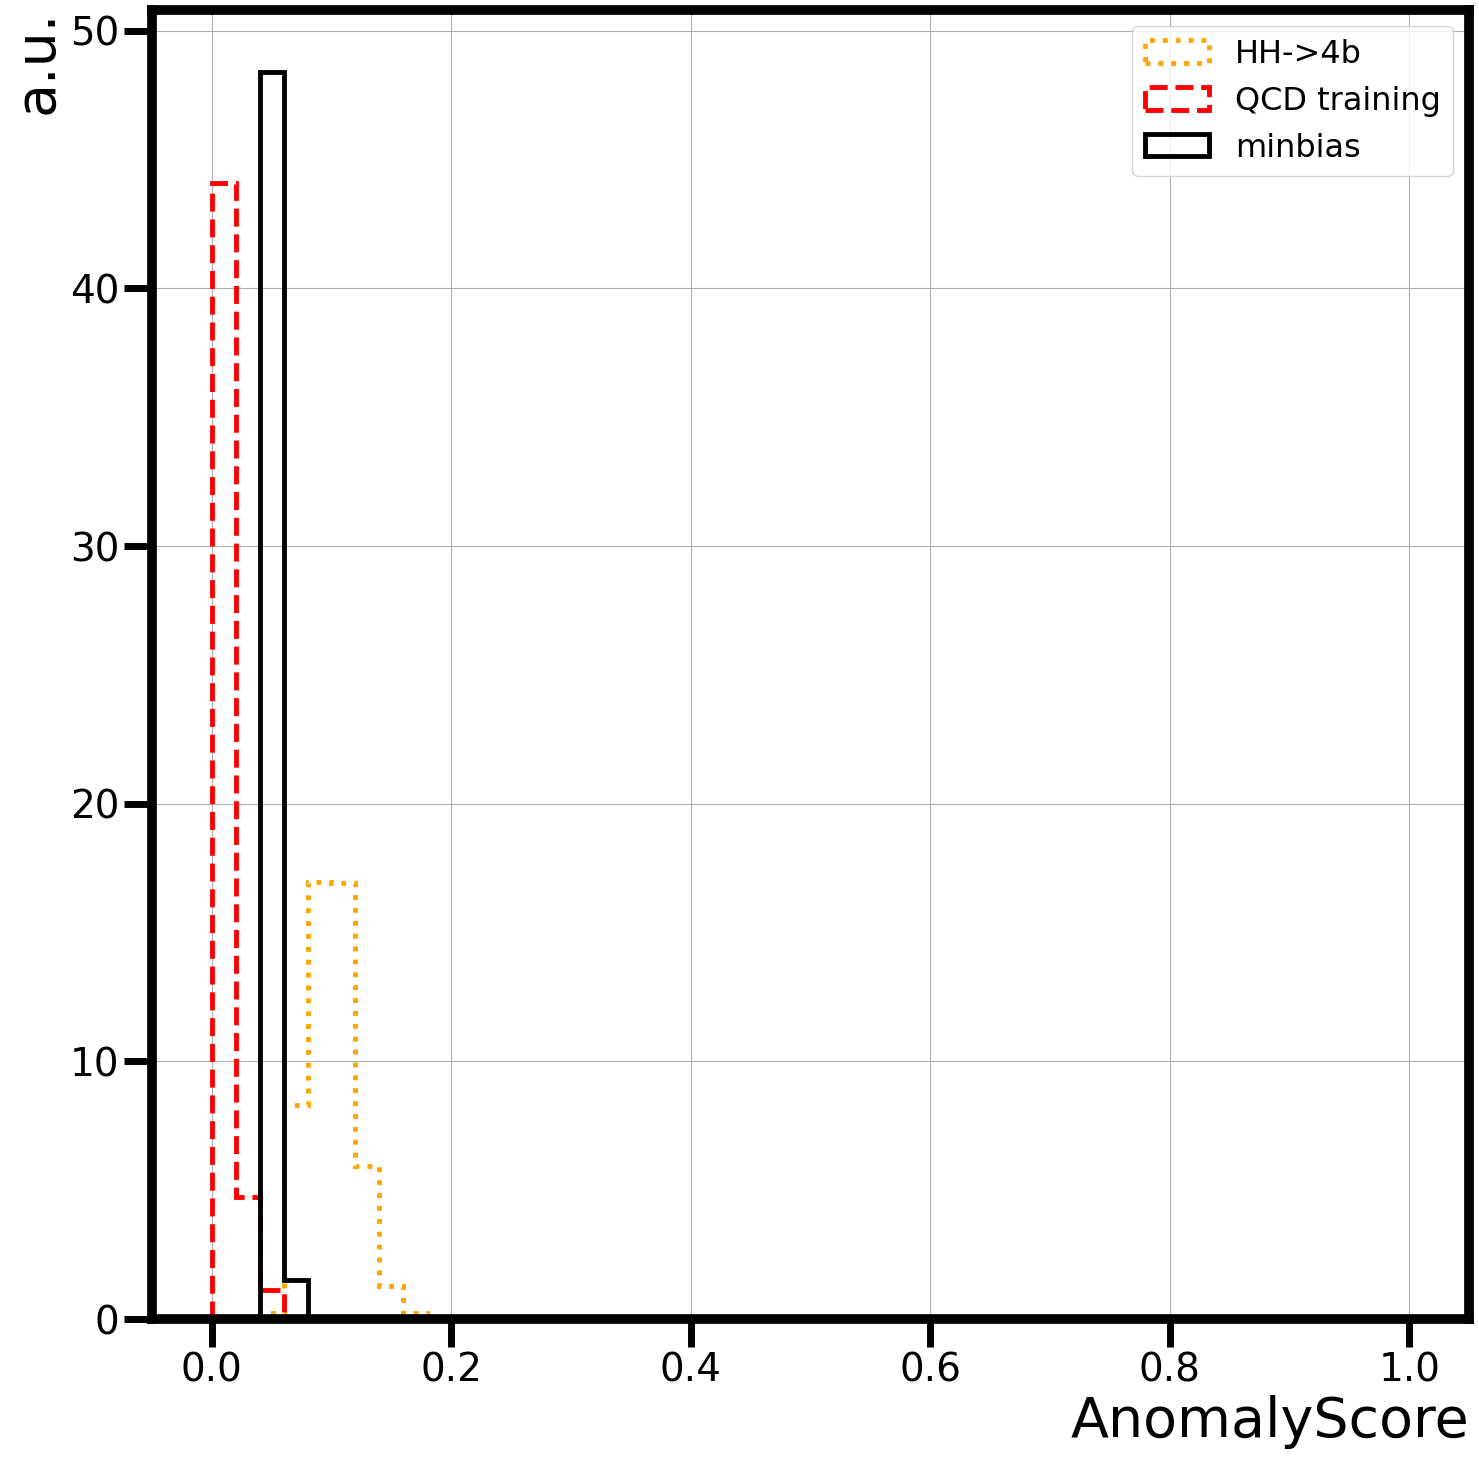

<Figure size 640x480 with 0 Axes>

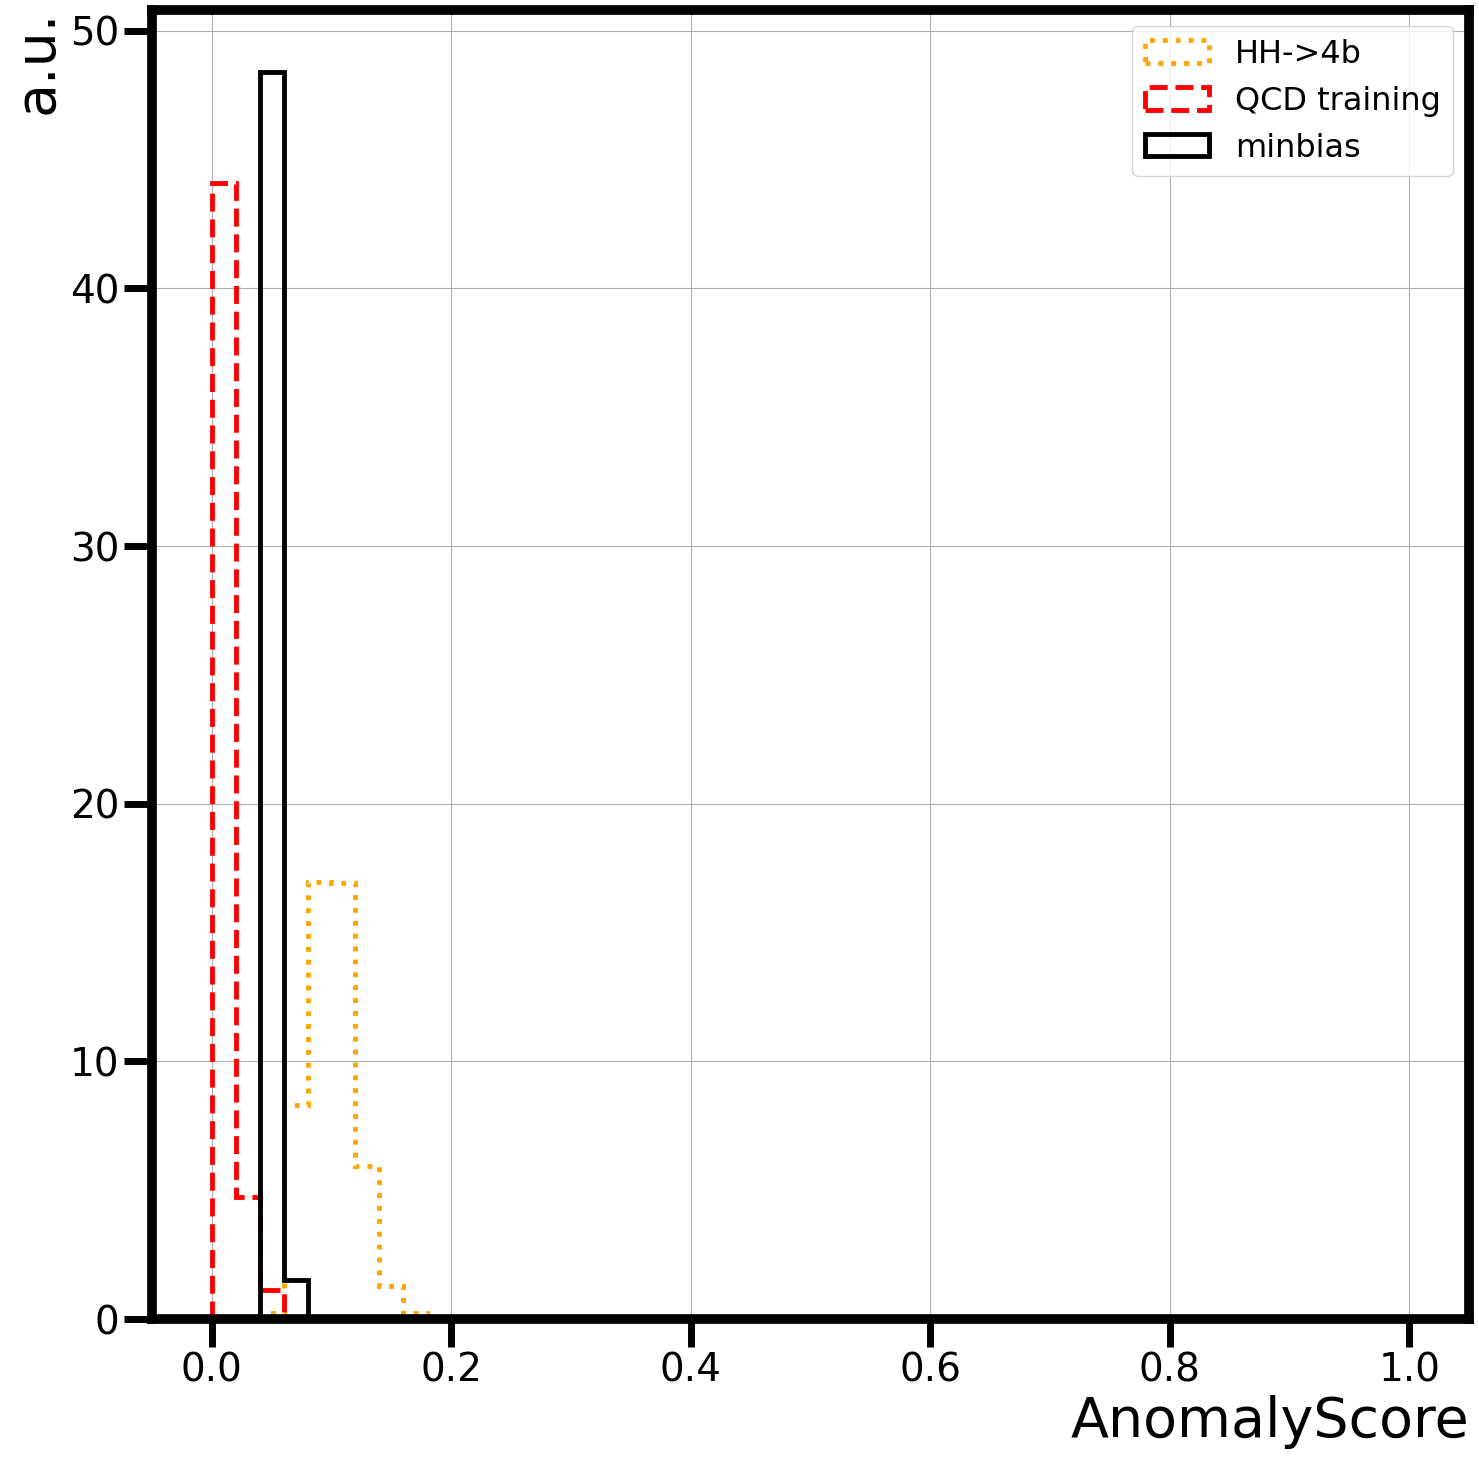

In [12]:
from plot import style
from plot.basic import error_residual, plot_histo, rates,efficiency

minbias_data_set.normalise()
hhbbbb_data_set.normalise()

minbias_outputs = AE_model.predict(minbias_data_set.get_training_dataset()) 
QCD_outputs = AE_model.predict(QCD_data_set.get_training_dataset()) 
hhbbbb_outputs = AE_model.predict(hhbbbb_data_set.get_training_dataset()) 

normalised_minbias_outputs = minbias_outputs/max(hhbbbb_outputs)
normalised_QCD_outputs = QCD_outputs/max(hhbbbb_outputs)
normalised_hhbbbb_outputs = hhbbbb_outputs/max(hhbbbb_outputs)

plot_histo([minbias_outputs,QCD_outputs,hhbbbb_outputs], 
           ['minbias','QCD training', 'HH->4b'], 
            '', 
            'AnomalyScore', 
            'a.u.', 
            log = 'linear', 
            x_range=(0, 1), 
            bins = 50)

Now let's pretend this algorithm is in a trigger. First let's derive the trigger rate, i.e how many times we accept a trigger decision. We base rates on a minbias sample. At an anomaly detection threshold of 0 our trigger rate should be 100% and at a threshold of 1 our trigger rate should be 0. Between 0 and 1 we divide the threshold up into equally sized bins and work out what percentage of minimum bias events we encapsulate within that threshold thus giving us the background rate of our trigger for a given model threshold.

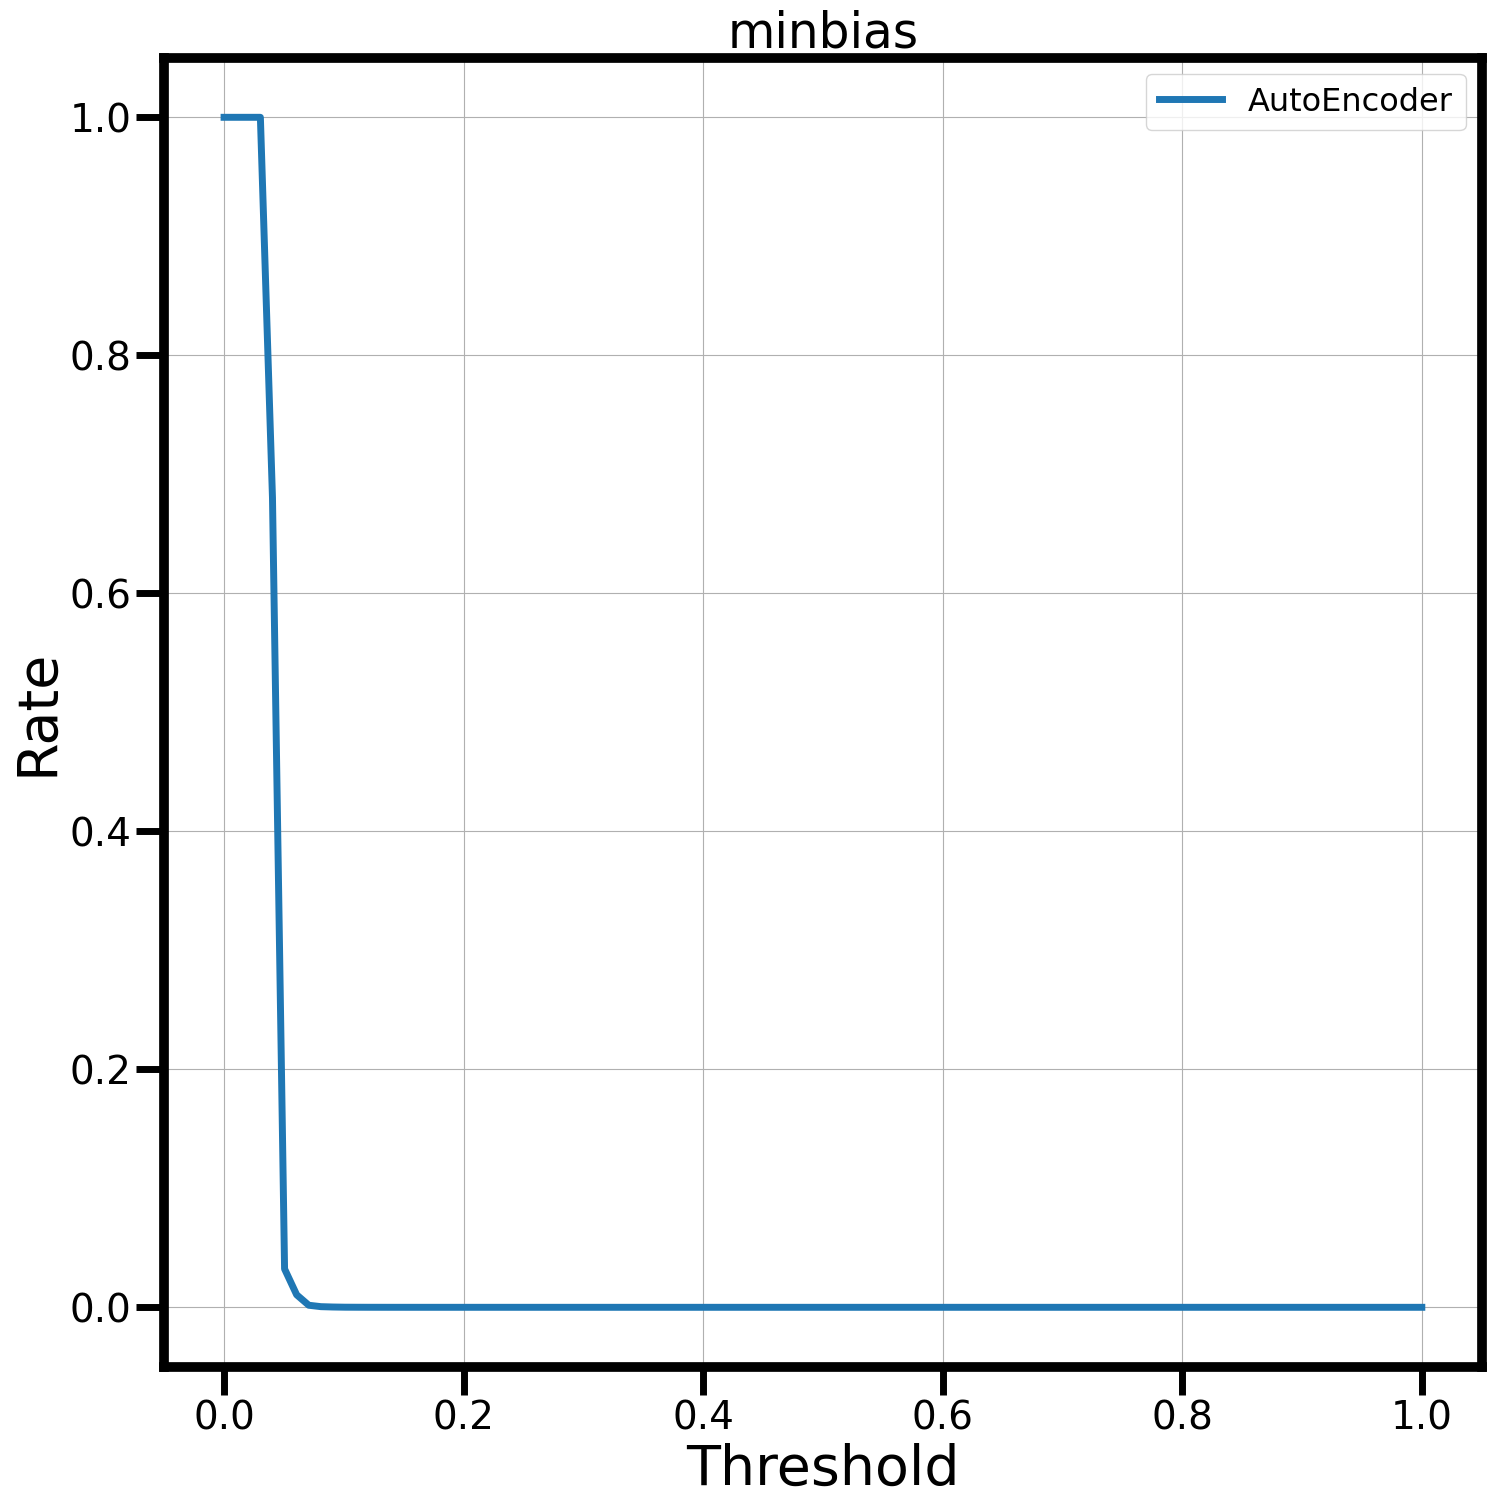

In [13]:
minbias_rates = rates("AutoEncoder",'minbias',minbias_outputs)

Now we can calculate the efficiency of the model with a given sample. For all samples the efficiency is 0 at a threshold of 0 and 100% at a threshold of 1. As we vary the threshold we capture more of the distribution of events, imagine sweeping a line from right to left of the model output plot and summing the % of total events above that threshold, for QCD we see the drop off in efficiency at a low value of the threshold but for HHbbbb as they look more anomalous a higher threshold can capture the events. 

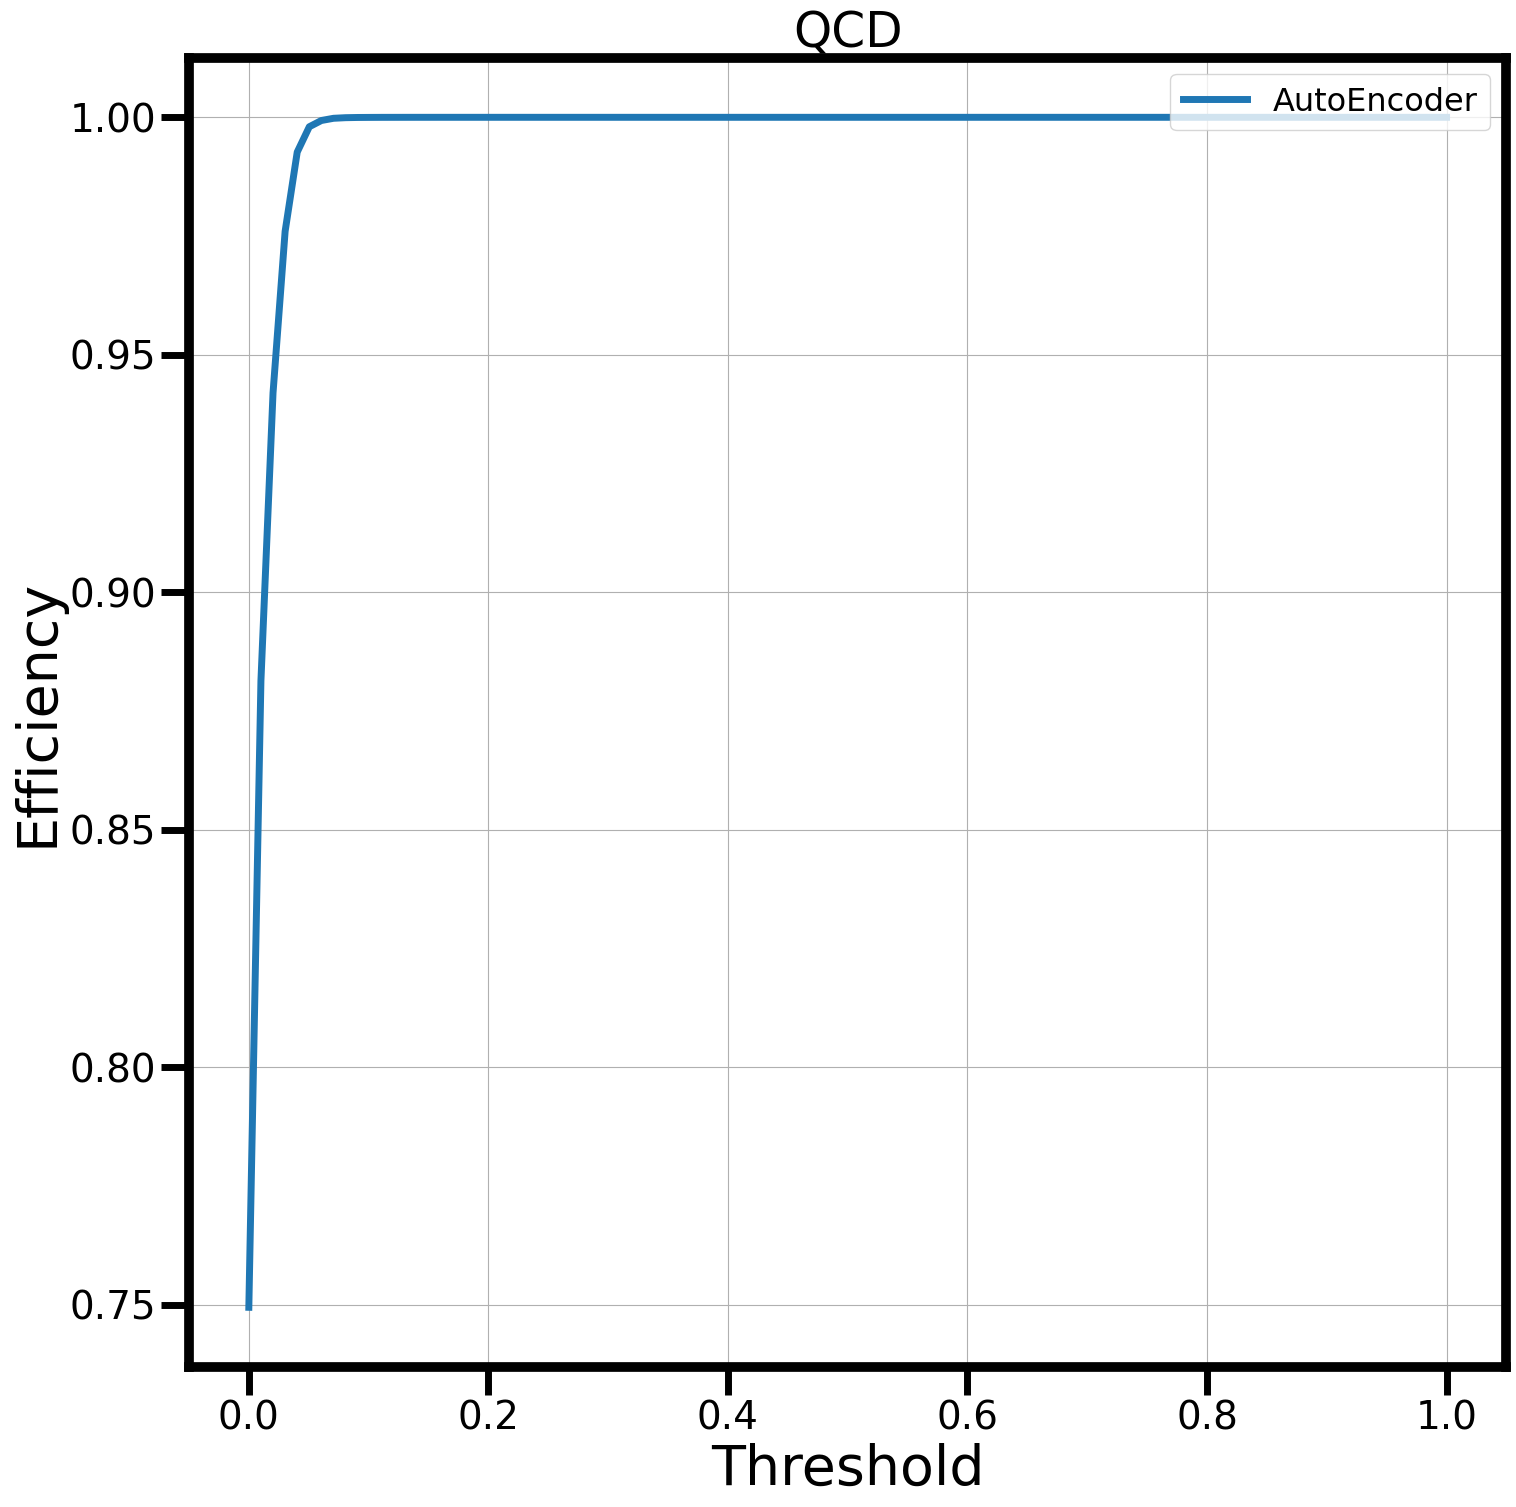

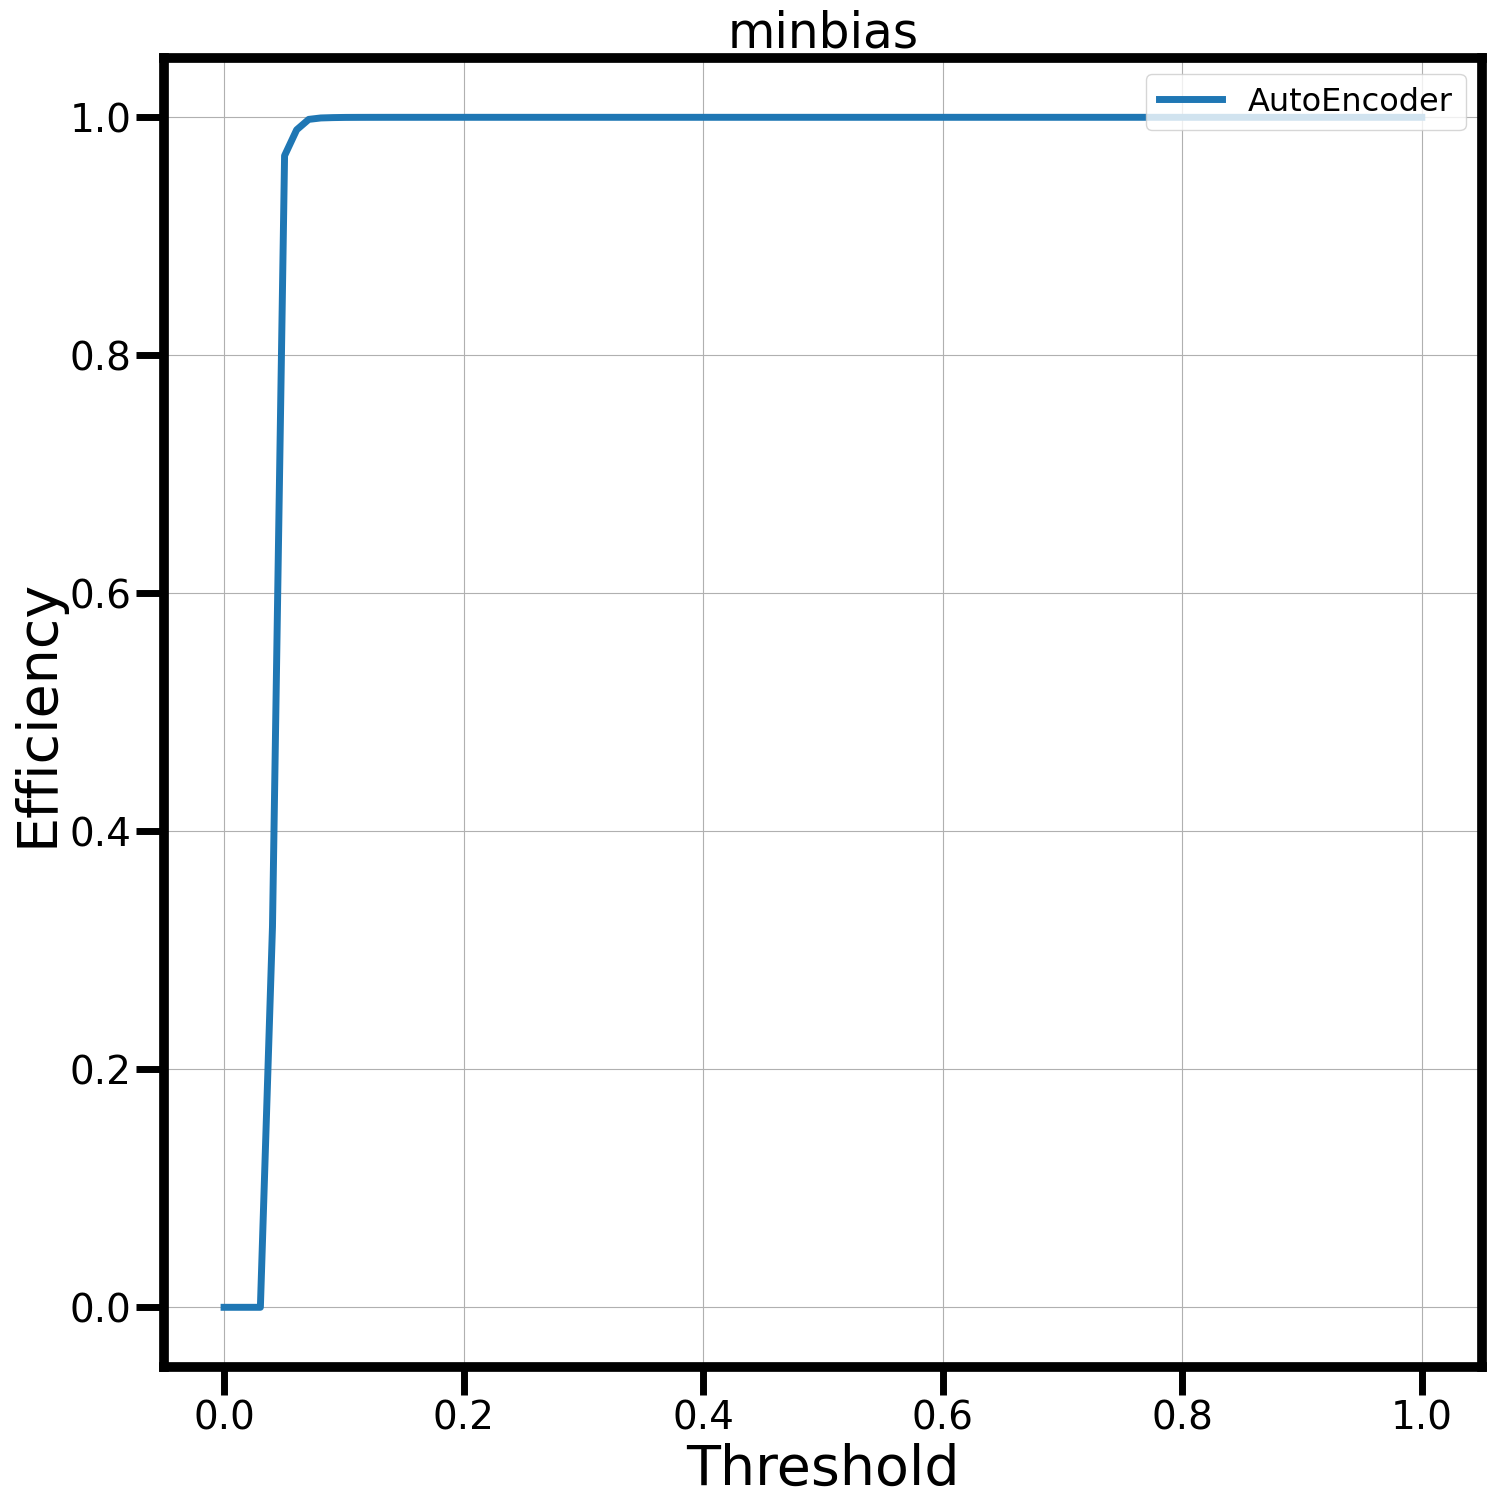

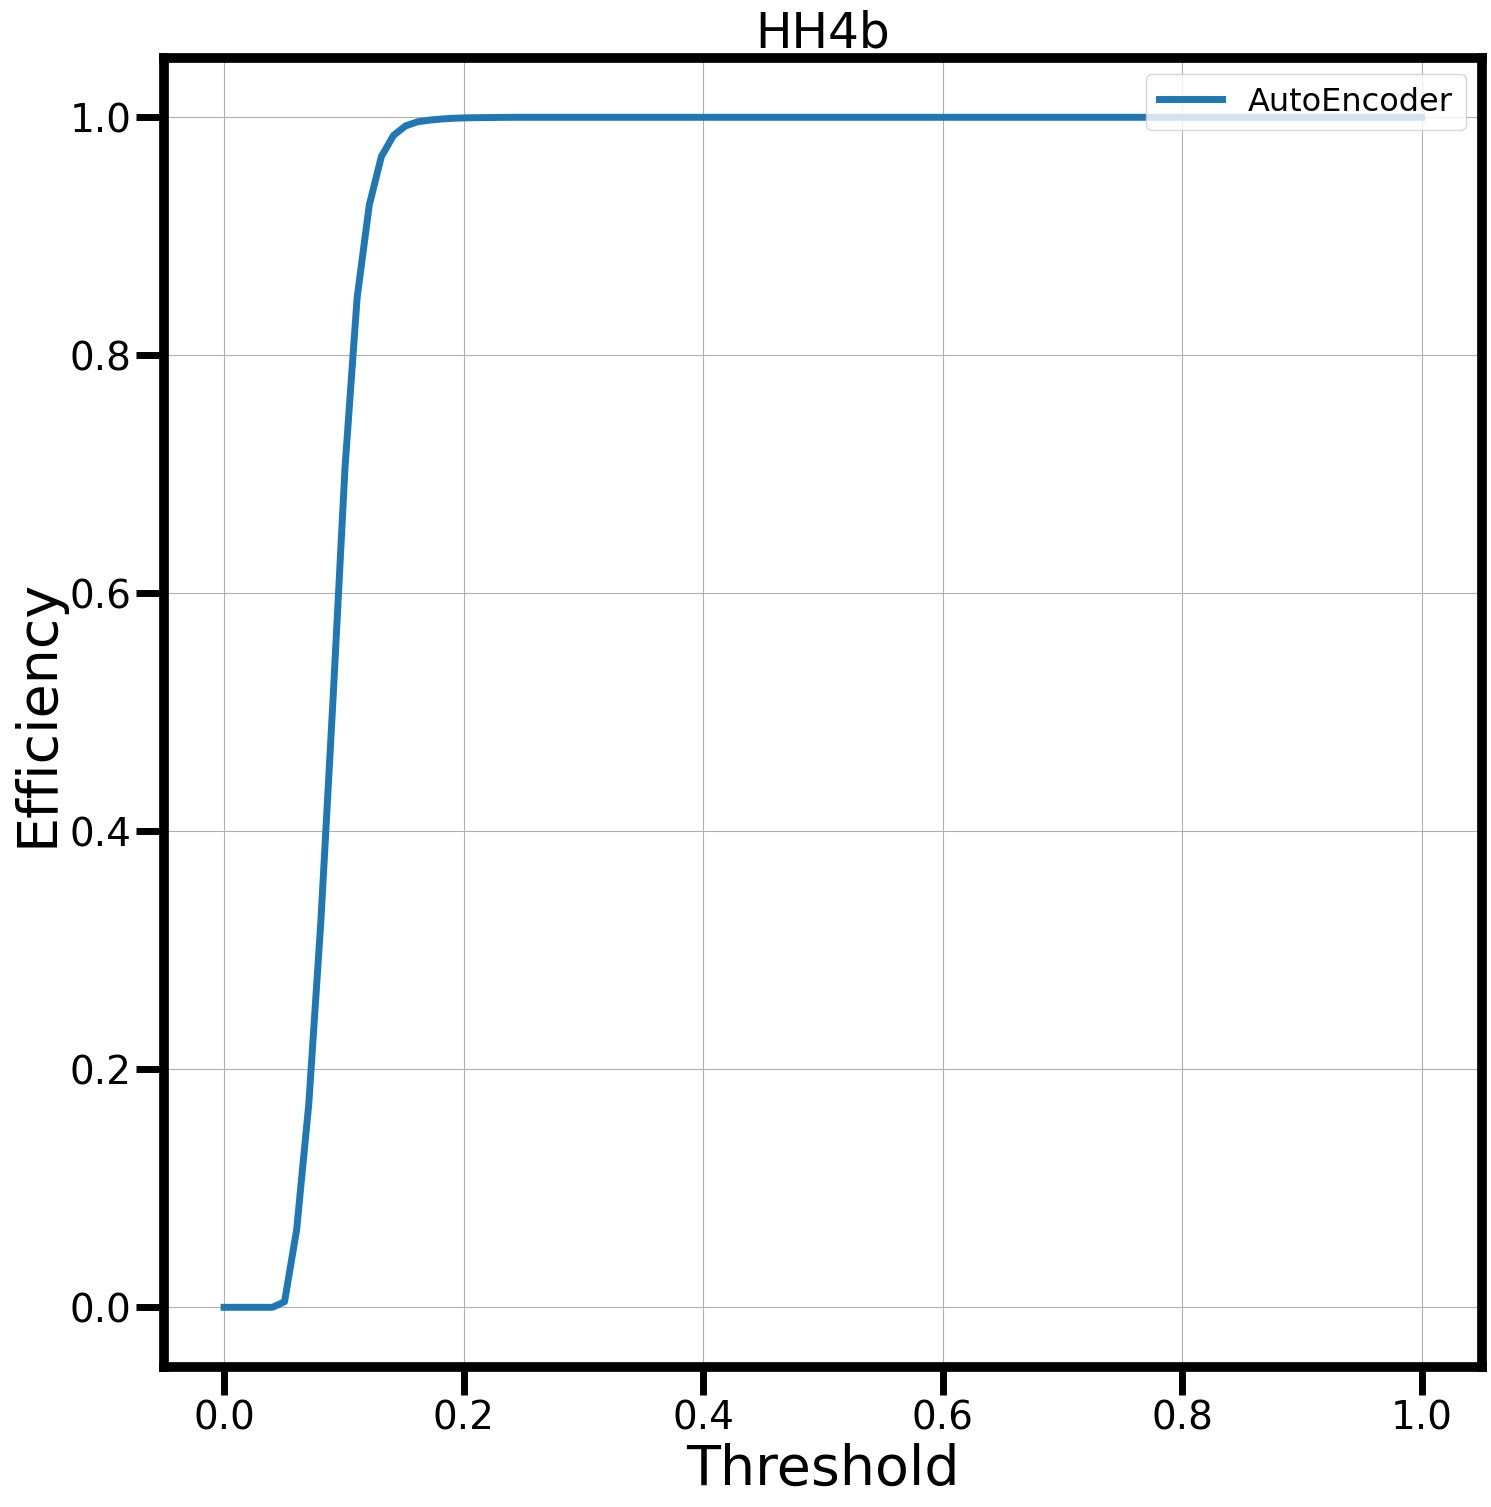

In [14]:
QCD_efficiency= efficiency('AutoEncoder','QCD',QCD_outputs)
minbias_efficiency = efficiency('AutoEncoder','minbias',minbias_outputs)
hhbbbb_efficiency = efficiency('AutoEncoder','HH4b',hhbbbb_outputs)

The ROC plot lets us viualise this properly. Imagine starting in the top right corner of the plot,the threshold is 0 , we let through all events, the efficiency for all samples is 1 but the rate is also 1. As we step up in threshold we let fewer events through but because our anomalous sample has high anomaly score we are still seeing all of that distribution pass our threshold but less and less of the minbias events pass so the minbis efficiency falls as the threshold rises. The rate for all samples drops as the threshold rises as the rate is just telling us the minbias efficiency. At a middle threshold we let through half the minbias events so see 50% efficiency and 50% rate but far higher hhbbbb efficiency for the same rate because our threshold lets through more of the events. Our trigger is therefore better. At lower background rates we achieve higher efficiencies in our signal.

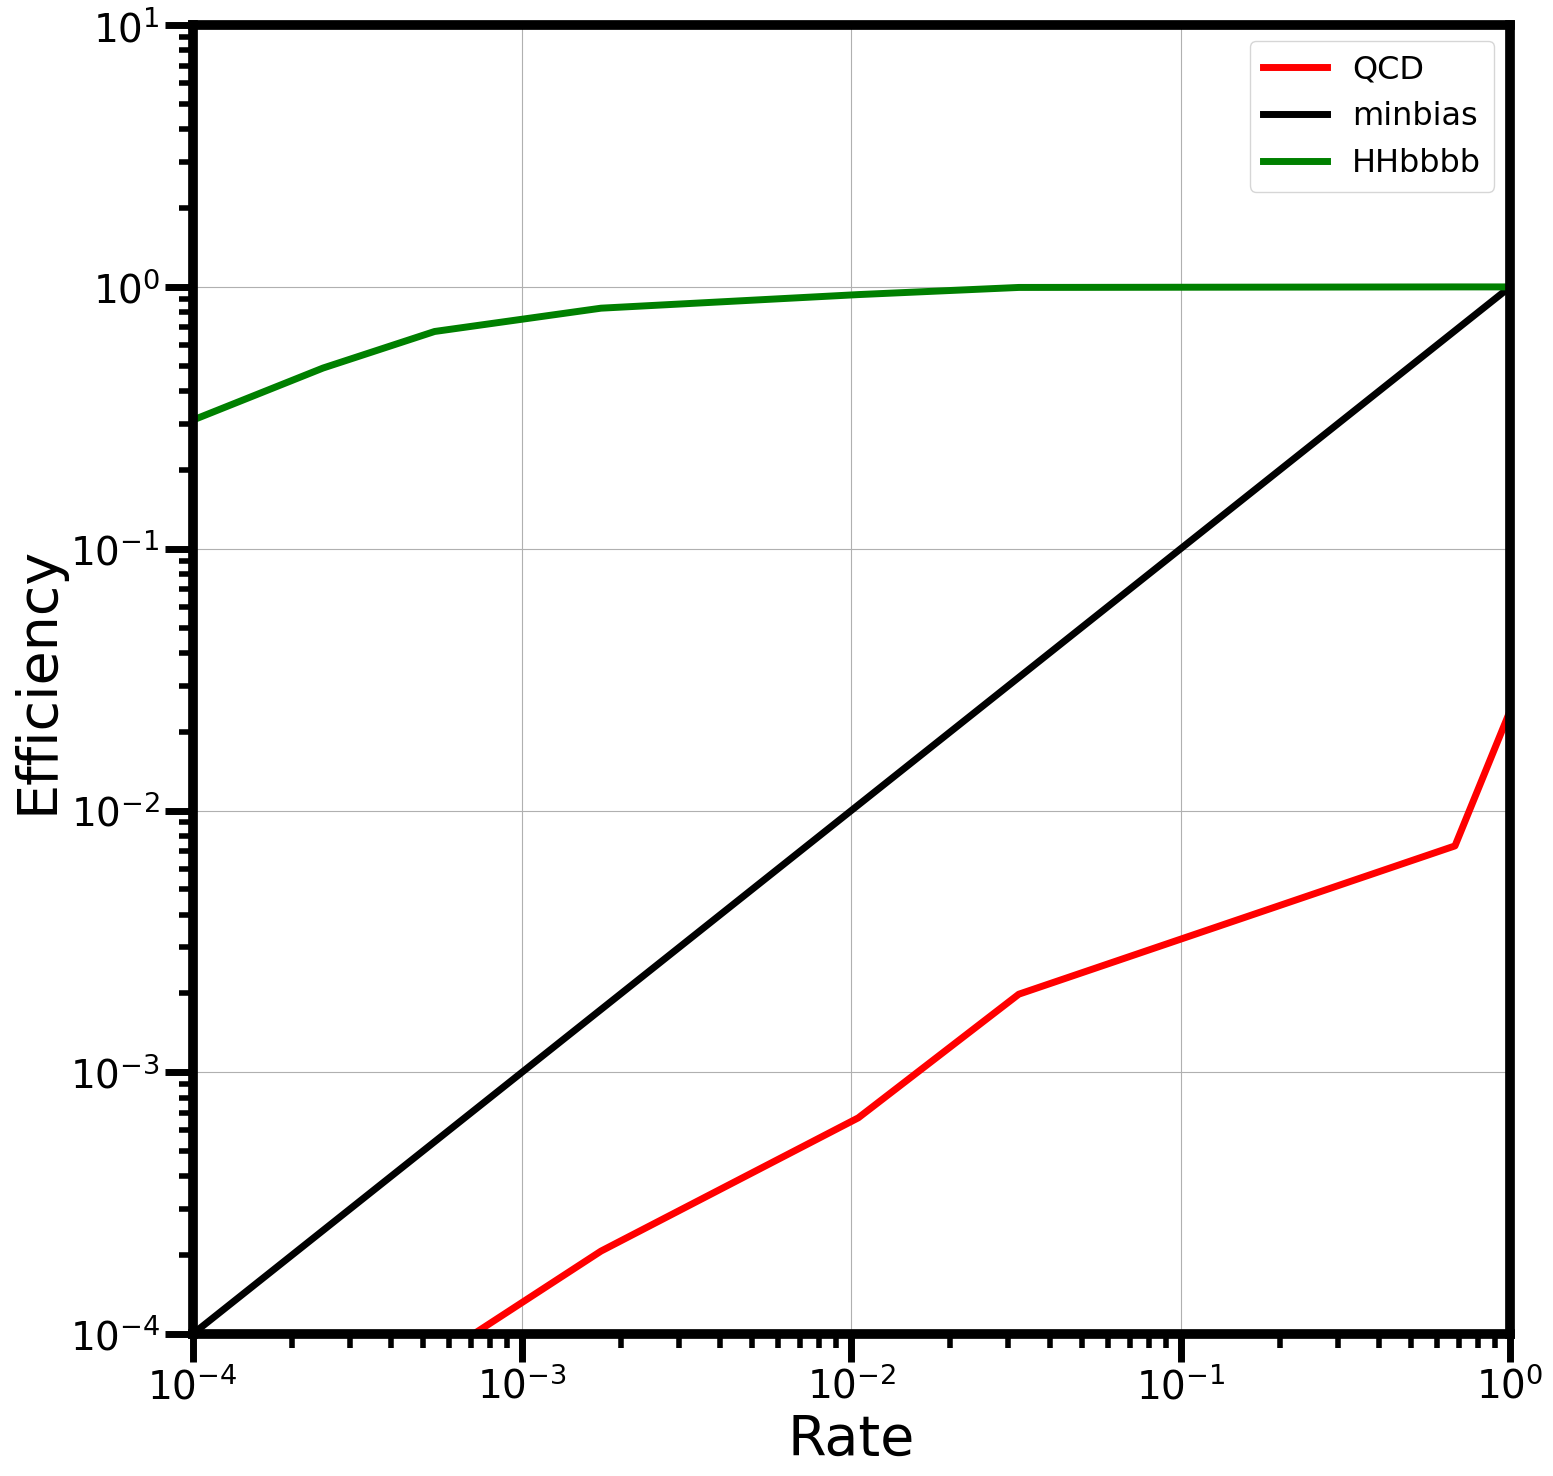

In [17]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=style.FIGURE_SIZE)
ax.plot(minbias_rates,QCD_efficiency, label='QCD', color='red', linewidth=style.LINEWIDTH)
ax.plot(minbias_rates,minbias_efficiency, label='minbias', color='black', linewidth=style.LINEWIDTH)
ax.plot(minbias_rates,hhbbbb_efficiency, label='HHbbbb', color='green', linewidth=style.LINEWIDTH)

ax.grid(True)
ax.set_ylabel('Efficiency')
ax.set_xlabel('Rate')
ax.legend(loc='upper right')
ax.set_xlim(0.0001,1)
ax.set_ylim(0.0001,10)
ax.set_xscale("log")
ax.set_yscale("log")